<h1>Least-squares Optimization with Theseus</h1>
This tutorial demonstrates how to solve a curve-fitting problem with Theseus. The examples in this tutorial are inspired by the [Ceres](https://ceres-solver.org/) [tutorial](http://ceres-solver.org/nnls_tutorial.html), and structured like the [curve-fitting example](http://ceres-solver.org/nnls_tutorial.html#curve-fitting) and [robust curve-fitting example](http://ceres-solver.org/nnls_tutorial.html#robust-curve-fitting) in Ceres.

<h2>Quadratic curve-fitting</h2>
In this tutorial, we will show how we can fit a quadratic function: <i>y = ax<sup>2</sup> + b</i>

<h3>Step 0: Generating Data</h3>
We first generate data by sampling points from the quadratic function <i>x<sup>2</sup> + 0.5</i>. To this, we add Gaussian noise with <i>&sigma; = 0.01</i>.

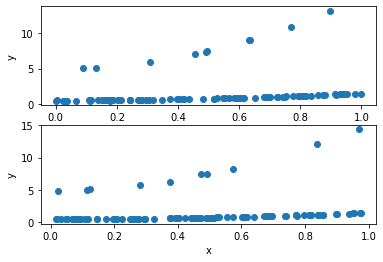

In [354]:
import torch

torch.manual_seed(0)

def generate_data(num_points=100, a=1, b=0.5, noise_factor=0.01):
    # Generate data: 100 points sampled from the quadratic curve listed above
    data_x = torch.rand((3, num_points))
    noise = torch.randn((3, num_points)) * noise_factor
    data_y = a * data_x.square() + b + noise
    return data_x, data_y

data_x, data_y = generate_data()

data_y[:,0:10] = data_y[:,0:10] * 10
# Plot the data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].scatter(data_x[0], data_y[0]);
ax[0].set_xlabel('x');
ax[0].set_ylabel('y');

ax[1].scatter(data_x[1], data_y[1]);
ax[1].set_xlabel('x');
ax[1].set_ylabel('y');

We demonstrate how to use Theseus to solve this curve-fitting problem in 3 steps:
<ul>
<li>Step 1: Represent data and variables
<li>Step 2: Set up optimization
<li>Step 3: Run optimization
</ul>

<h3>Step 1: Represent data and variables in Theseus</h3>
As we described in Tutorial 0, Theseus Variables are semantically divided into two main classes:
<ul>
<li><i>optimization variables</i>: those that will be modified by our non-linear least-squares optimizers to minimize the total cost function
<li><i>auxiliary variables</i>: other variables required by the cost functions to carry out the optimization, but which will not be optimized by the non-linear least-squares optimizers, e.g., application data in this example (we will see more examples of )
</ul>

Our first step is to represent the data <i>(x, y)</i> and the optimization variables (<i>a</i> and <i>b</i>) in Theseus data structures.
The optimization variables must be of type `Manifold`. For this example, we choose its `Vector` sub-class to represent <i>a</i> and <i>b</i>. Because they are one-dimensional quantities, we require only 1 degree-of-freedom in initializing these `Vector` objects. (Alternately, we could also represent both variables as a single 2-dimensional `Vector` object; however, this would change how the error functions are written.) The (auxiliary) data variables may be an instance of any `Variable` type. For this example, the type `Variable` itself suffices.

In [355]:
import theseus as th

# data is of type Variable
x = th.Variable(data_x, name="x")
y = th.Variable(data_y, name="y")

# optimization variables are of type Vector with 1 degree of freedom (dof)
a = th.Vector(1, name="a")
b = th.Vector(1, name="b")
ab = th.Vector(2, name="ab")

<h3>Step 2: Set up optimization</h3> 
    
The residual errors of the least-squares fit is captured in a `CostFunction`. In this example, we will use the `AutoDiffCostFunction` provided by Theseus, which provides an easy-to-use way to capture arbitrary cost functions. The `AutoDiffCostFunction` only requires that we define the optimization variables and the auxiliary variables, and provide an error function that computes the residual errors. From there, it uses the PyTorch autograd to compute the Jacobians for the optimization variables via automatic differentiation. 

In the example below, the `quad_error_fn` captures the least-squares error of the quadratic function fitted with the two 1-dimensional `Vector` objects `a`, `b`. 

The total least-squares error can be captured by either one 100-dimensional `AutoDiffCostFunction` (where each dimension represents the error of one data point), or a set of 100 one-dimensional `AutoDiffCostFunction` (where instead each cost function captures the error of one data point). We use the former (i.e., one 100-dimensional `AutoDiffCostFunction`) in this example, but we will see examples of the latter in Tutorials 4 & 5.

Finally, we combine the cost functions into a Theseus optimization problem:
- The optimization criteria is represented by the `Objective`. This is constructed by adding all the cost functions to it.
- We can then choose an optimizer and set some of its default configuration (e.g., `GaussNewton` with `max_iterations=15` in the example below).
- The objective and its associated optimizer are then used to construct the `TheseusLayer`, which represents one layer of optimization

In [356]:
import warnings
from typing import List, Optional, Tuple, Type

import torch
import theseus as th
import abc

from theseus.core.cost_weight import CostWeight
from theseus.core.variable import Variable
#from theseus.core.robust_loss import RobustLoss
#from theseus.core.robust_cost_function import RobustCostFunction

In [357]:
_LOSS_EPS = 1e-20
class RobustLoss(abc.ABC):
    # .suqre() make it easier to compare with residual.square(), which is x
    @classmethod
    def evaluate(cls, x: torch.Tensor, log_radius: torch.Tensor) -> torch.Tensor:
        return cls._evaluate_impl(x, log_radius.square()) 
    
    @classmethod
    def linearize(cls, x: torch.Tensor, log_radius: torch.Tensor) -> torch.Tensor:
        return cls._linearize_impl(x, log_radius.square())

    @staticmethod
    @abc.abstractmethod
    def _evaluate_impl(x: torch.Tensor, radius: torch.Tensor) -> torch.Tensor:
        pass

    @staticmethod
    @abc.abstractmethod
    def _linearize_impl(x: torch.Tensor, raidus: torch.Tensor) -> torch.Tensor:
        pass


class WelschLoss(RobustLoss):
    @staticmethod
    def _evaluate_impl(x: torch.Tensor, radius: torch.Tensor) -> torch.Tensor:
        return radius - radius * torch.exp(-x / (radius + _LOSS_EPS))

    @staticmethod
    def _linearize_impl(x: torch.Tensor, radius: torch.Tensor) -> torch.Tensor:
        return torch.exp(-x / (radius + _LOSS_EPS))


class HuberLoss(RobustLoss):
    @staticmethod
    def _evaluate_impl(x: torch.Tensor, radius: torch.Tensor) -> torch.Tensor:
        return torch.where(
            x > radius, 2 * torch.sqrt(radius * x.max(radius) + _LOSS_EPS) - radius, x
        )


    @staticmethod
    def _linearize_impl(x: torch.Tensor, radius: torch.Tensor) -> torch.Tensor:
        return torch.sqrt(radius / torch.max(x, radius) + _LOSS_EPS)


In [358]:
class RobustCostFunction(th.CostFunction):
    _EPS = 1e-20

    def __init__(
        self,
        cost_function: th.CostFunction,
        loss_cls: Type[RobustLoss],
        log_loss_radius: Variable,
        RobustSum: bool = False,
        name: Optional[str] = None,
    ):
        self.cost_function = cost_function
        super().__init__(cost_function.weight, name=name)

        # Register optimization variables of the underlying cost function
        for attr in cost_function._optim_vars_attr_names:
            setattr(self, attr, getattr(cost_function, attr))
            self.register_optim_var(attr)

        # Register auxiliary variables of the underlying cost function
        for attr in cost_function._aux_vars_attr_names:
            setattr(self, attr, getattr(cost_function, attr))
            self.register_aux_var(attr)

        self.log_loss_radius = log_loss_radius
        self.register_aux_var("log_loss_radius")
        self.loss = loss_cls()
        self.RobustSum = RobustSum

    def error(self) -> torch.Tensor:
        warnings.warn(
            "Computing the robust cost error requires weighting first, so "
            "error() is equivalent to weighted_error()."
        )
        return self.weighted_error()

    def weighted_error(self) -> torch.Tensor:
        weighted_error = self.cost_function.weighted_error()
        
        if self.RobustSum:
            squared_norm = torch.sum(weighted_error**2, dim=1, keepdim=True)
            error_loss = self.loss.evaluate(squared_norm, self.log_loss_radius.tensor)
            return (
            torch.ones_like(weighted_error)
            * (error_loss / self.dim() + RobustCostFunction._EPS).sqrt()
            )
        else:
            squared_norm = weighted_error**2
            error_loss = self.loss.evaluate(squared_norm, self.log_loss_radius.tensor)
            return (
              (error_loss  + RobustCostFunction._EPS).sqrt()
            )
        # Inside will compare squared_norm with exp(radius)
        
        #print(weighted_error, error_loss)
        #print("scaled", error_loss)
        #print(self.dim())
        # The return value is a hacky way to make it so that
        # ||weighted_error||^2 = error_loss
        # By doing this we avoid having to change the objective's error computation
        # specifically for robust cost functions. The issue for this type of cost
        # function is that the theory requires us to maintain scaled errors/jacobians
        # of dim = robust_fn.cost_function.dim() to do the linearization properly,
        # but the actual error has dim = 1, being the result of loss(||error||^2).
        

    def jacobians(self) -> Tuple[List[torch.Tensor], torch.Tensor]:
        warnings.warn(
            "Computing the robust cost error requires weighting first, so "
            "jacobians() is equivalent to weighted_jacobians_error()."
        )
        return self.weighted_jacobians_error()

    def weighted_jacobians_error(self) -> Tuple[List[torch.Tensor], torch.Tensor]:
        (
            weighted_jacobians,
            weighted_error,
        ) = self.cost_function.weighted_jacobians_error()
        #squared_norm = torch.sum(weighted_error**2, dim=1, keepdim=True)
        #print(len(weighted_jacobians), weighted_error.shape, weighted_error.dim(), self.cost_function.dim())
        
        # I do not check the linearization part. I assume they should be correct
        
        #print(rescale.shape)
        # The rescale should be reshape as the jocobian shape such that the multipilication works and fulfill the chain rule

        
        if self.RobustSum:
        
            squared_norm = torch.sum(weighted_error**2, dim=1, keepdim=True)
            rescale = (
                self.loss.linearize(squared_norm, self.log_loss_radius.tensor)
                + RobustCostFunction._EPS
            ).sqrt()

            return [
                rescale.view(-1, 1, 1) * jacobian for jacobian in weighted_jacobians
            ], rescale * weighted_error
        
        else:
            squared_norm = weighted_error**2
            rescale = (
                self.loss.linearize(squared_norm, self.log_loss_radius.tensor)
                + RobustCostFunction._EPS
            ).sqrt()
            
            for jacobian in weighted_jacobians:
                rescale_tile = rescale.unsqueeze(2)
                rescale_tile = torch.tile(rescale_tile, (1, 1, jacobian.shape[2]))

            return [
                rescale_tile * jacobian for jacobian in weighted_jacobians
            ], rescale * weighted_error
        
        

    def dim(self) -> int:
        return self.cost_function.dim()

    def _copy_impl(self, new_name: Optional[str] = None) -> "RobustCostFunction":
        return RobustCostFunction(
            self.cost_function.copy(),
            type(self.loss),
            self.log_loss_radius.copy(),
            name=new_name,
        )

    @property
    def weight(self) -> CostWeight:
        return self.cost_function.weight

    @weight.setter
    def weight(self, weight: CostWeight):
        self.cost_function.weight = weight

    @property
    def _supports_masking(self) -> bool:
        return self.__supports_masking__

    @_supports_masking.setter
    def _supports_masking(self, val: bool):
        self.cost_function._supports_masking = val
        self.__supports_masking__ = val

In [359]:
def quad_error_fn(optim_vars, aux_vars):
    a, b = optim_vars 
    x, y = aux_vars
    est = a.tensor * x.tensor.square() + b.tensor
    err = y.tensor - est
    return err

def quad_error_fn_ab(optim_vars, aux_vars):
    [ab] = optim_vars 
    x, y = aux_vars
    #print(x.shape ,"ab",ab.tensor.shape)
    est = ab.tensor[:,0] * x.tensor.square() + ab.tensor[:,1]
    #print("est", est.shape)
    err = y.tensor - est
    #print("err", err)
    return err

optim_vars_ab = [ab]
optim_vars = a, b
aux_vars = x, y
cost_function = th.AutoDiffCostFunction(
    optim_vars, quad_error_fn, 100, aux_vars=aux_vars, name="quad_error_fn")

log_loss_radius = th.Vector(1, name="log_loss_radius", dtype=torch.float32)
robust_cost_function = RobustCostFunction(
            cost_function,
            HuberLoss,
            log_loss_radius,
            True,
            name=f"robust_{cost_function.name}",
        )

objective_ori = th.Objective()
objective_ori.add(cost_function)
optimizer_ori = th.GaussNewton(
    objective_ori,
    max_iterations=15,
    step_size=0.5,
)
theseus_optim_ori = th.TheseusLayer(optimizer_ori)

objective_robust = th.Objective()
objective_robust.add(robust_cost_function)
optimizer_robust = th.GaussNewton(
    objective_robust,
    max_iterations=15,
    step_size=0.5,
)
theseus_optim_robust = th.TheseusLayer(optimizer_robust)

<h3>Step 3: Run optimization</h3> 
Running the optimization problem now only requires that we provide the input data and initial values, and call the forward function on the `TheseusLayer`.

The input is provided as a dictionary, where the keys represent either the optimization variables (which are paired with their initial values), or the auxiliary variables (which are paired with their data). The dictionary `theseus_inputs` shows an example of this.

With this input, we can now run the least squares optimization in Theseus. We do this by calling the `forward` function on the `TheseusLayer`. Two quantities are returned after each call to the `forward` function:
1. The `updated_inputs` object, which holds the final values for the optimized variables, along with unchanged auxiliary variable values. This allows us to use the `updated_inputs` as input to downstream functions or Theseus layers (e.g., for problems that require multiple forward passes, as we will see in Tutorial 2.)
2. The `info` object, which can track the best solution if necessary, and holds other useful information about the optimization. The best solution is useful to track because the optimization algorithm does not stop if the error increases from an earlier iteration. (The best solution is not as useful when backpropagation is carried out, because backpropagation uses the entire optimization sequence; see Tutorial 2.)

/home/ph/anaconda3/envs/FGO/lib/python3.10/site-packages/theseus/core/objective.py:547: UserWarning: Attempted to update a tensor with name log_loss_radius, which is not associated to any variable in the objective.
  warnings.warn(


tensor([[ 6.0040,  8.8577,  4.0446,  3.9421,  4.6637,  7.3445,  5.9278, 10.8919,
          5.6236,  7.3983, -0.6318, -0.6459, -0.5974, -0.5923, -0.6334, -0.7107,
         -0.7834, -0.8400, -0.5917, -0.6297, -0.7797, -0.9340, -0.6467, -0.8917,
         -0.6644, -0.7159, -0.9777, -0.5908, -0.6119, -0.6303, -0.6215, -0.9411,
         -0.6257, -0.6238, -0.5898, -0.5827, -0.5968, -0.9054, -0.8039, -0.8114,
         -0.6762, -0.5934, -0.7304, -0.6008, -0.5738, -0.6225, -0.8852, -0.8675,
         -0.6205, -0.6824, -0.8595, -1.0145, -0.7826, -0.7038, -0.8644, -0.5903,
         -0.7259, -0.6048, -0.5878, -0.6232, -0.7958, -0.7889, -0.5948, -0.7712,
         -0.8223, -0.6656, -0.6759, -0.7422, -0.8531, -0.9758, -0.5868, -0.6123,
         -0.7750, -0.9064, -0.9465, -0.9503, -0.7378, -0.5926, -0.7140, -0.6125,
         -0.5966, -0.9565, -0.9223, -0.6029, -0.7288, -0.6491, -0.6451, -0.6064,
         -0.7630, -0.6121, -0.7850, -0.8044, -0.8767, -0.7404, -0.5740, -0.6137,
         -0.8244, -0.7294, -

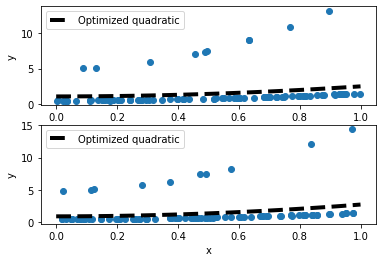

In [360]:
theseus_inputs = {
"x": data_x,
"y": data_y,
"a": 10 * torch.ones((3, 1)),
"b": 10*torch.ones((3, 1)),
"log_loss_radius": torch.zeros((3, 1)),
}
#print(data_x.shape)
with torch.no_grad():
    updated_inputs, info = theseus_optim_ori.forward(
        theseus_inputs, optimizer_kwargs={"track_best_solution": True, "verbose":False})
#print("Best solution:", info.best_solution)

# Plot the optimized function
fig, ax = plt.subplots(2,1)
ax[0].scatter(data_x[0], data_y[0]);
ax[1].scatter(data_x[1], data_y[1]);
a = info.best_solution['a'].squeeze()
b = info.best_solution['b'].squeeze()
x1 = torch.linspace(0., 1., steps=100)
y1 = a[0]*x1*x1 + b[0]
x2 = torch.linspace(0., 1., steps=100)
y2 = a[1]*x2*x2 + b[1]
ax[0].plot(x1, y1, color='k', lw=4, linestyle='--',
        label='Optimized quadratic')
ax[0].legend()

ax[0].set_xlabel('x');
ax[0].set_ylabel('y');


ax[1].plot(x2, y2, color='k', lw=4, linestyle='--',
        label='Optimized quadratic')
ax[1].legend()

ax[1].set_xlabel('x');
ax[1].set_ylabel('y');

print(objective_ori.error())

tensor([1.4160, 1.8174, 2.4521]) tensor([1.0855, 0.9499, 0.8132])
tensor([[0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292,
         0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292,
         0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292,
         0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292,
         0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292,
         0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292,
         0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292,
         0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292,
         0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292,
         0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292,
         0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292, 0.9292,
         0.9292],
        [0.9211, 0.9211, 

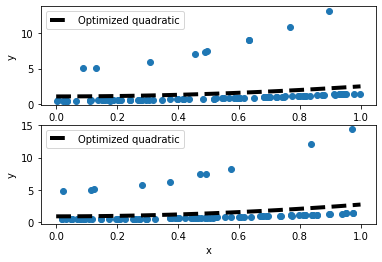

In [361]:
radius = 2 # change it larger than the outlinear residual, then it will perform as NO rubust function
theseus_inputs = {
"x": data_x,
"y": data_y,
"a": 10 * torch.ones((3, 1)),
"b": 10*torch.ones((3, 1)),
"log_loss_radius": torch.ones((3, 1))*radius,
}
#print(data_x.shape)
with torch.no_grad():
    updated_inputs, info = theseus_optim_robust.forward(
        theseus_inputs, optimizer_kwargs={"track_best_solution": True, "verbose":False})
#print("Best solution:", info.best_solution)

# Plot the optimized function
fig, ax = plt.subplots(2,1)
ax[0].scatter(data_x[0], data_y[0]);
ax[1].scatter(data_x[1], data_y[1]);
a = info.best_solution['a'].squeeze()
b = info.best_solution['b'].squeeze()
x1 = torch.linspace(0., 1., steps=100)
y1 = a[0]*x1*x1 + b[0]
x2 = torch.linspace(0., 1., steps=100)
y2 = a[1]*x2*x2 + b[1]
ax[0].plot(x1, y1, color='k', lw=4, linestyle='--',
        label='Optimized quadratic')
ax[0].legend()

ax[0].set_xlabel('x');
ax[0].set_ylabel('y');


ax[1].plot(x2, y2, color='k', lw=4, linestyle='--',
        label='Optimized quadratic')
ax[1].legend()

ax[1].set_xlabel('x');
ax[1].set_ylabel('y');

print(a, b)
print(objective_robust.error())